# Common

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
seed = 111
np.random.seed(seed)

# Importing libraries for visualization data
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Importing libraries for building the neural network
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.model_selection import train_test_split


In [39]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Data Preparation

In [40]:
file_path = "/content/drive/MyDrive/Dataset/heart_statlog_cleveland_hungary_final.csv"
df = pd.read_csv(file_path)

In [41]:
df.head(5)

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [42]:
# renaming features to proper name
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 
              'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 
              'max_heart_rate_achieved', 'exercise_induced_angina', 
              'st_depression', 'st_slope','target']

In [43]:
DROP = ['cholesterol', 'rest_ecg', 'st_depression', 'st_slope']
CONTI_COLS = ['age', 'sex', 'resting_blood_pressure', 
              'fasting_blood_sugar',
              'exercise_induced_angina', 'max_heart_rate_achieved'
              ]

CATE_COLS = ['chest_pain_type']
LABEL_COLS = "target"

In [44]:
df = df.drop(labels=DROP, axis=1)

In [45]:
df.head(5)

,age,sex,chest_pain_type,resting_blood_pressure,fasting_blood_sugar,max_heart_rate_achieved,exercise_induced_angina,target
0,40,1,2,140,0,172,0,0
1,49,0,3,160,0,156,0,1
2,37,1,2,130,0,98,0,0
3,48,0,4,138,0,108,1,1
4,54,1,3,150,0,122,0,0


# Data Visualization

In [46]:
df['target'].value_counts()

1    629
0    561
Name: target, dtype: int64

In [47]:
# Any empty values?
df.isnull().sum()

age                        0
sex                        0
chest_pain_type            0
resting_blood_pressure     0
fasting_blood_sugar        0
max_heart_rate_achieved    0
exercise_induced_angina    0
target                     0
dtype: int64

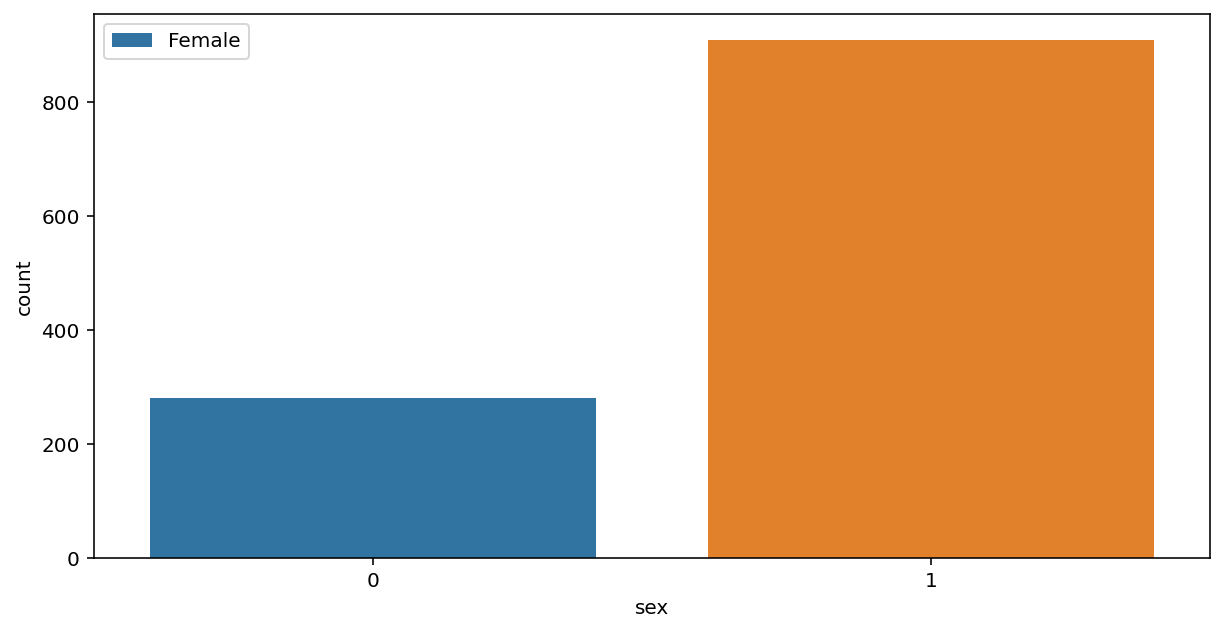

In [48]:
plt.figure(figsize=[10, 5])
sns.countplot(x='sex', data=df)
plt.legend(["Female", "Male"])
plt.show()

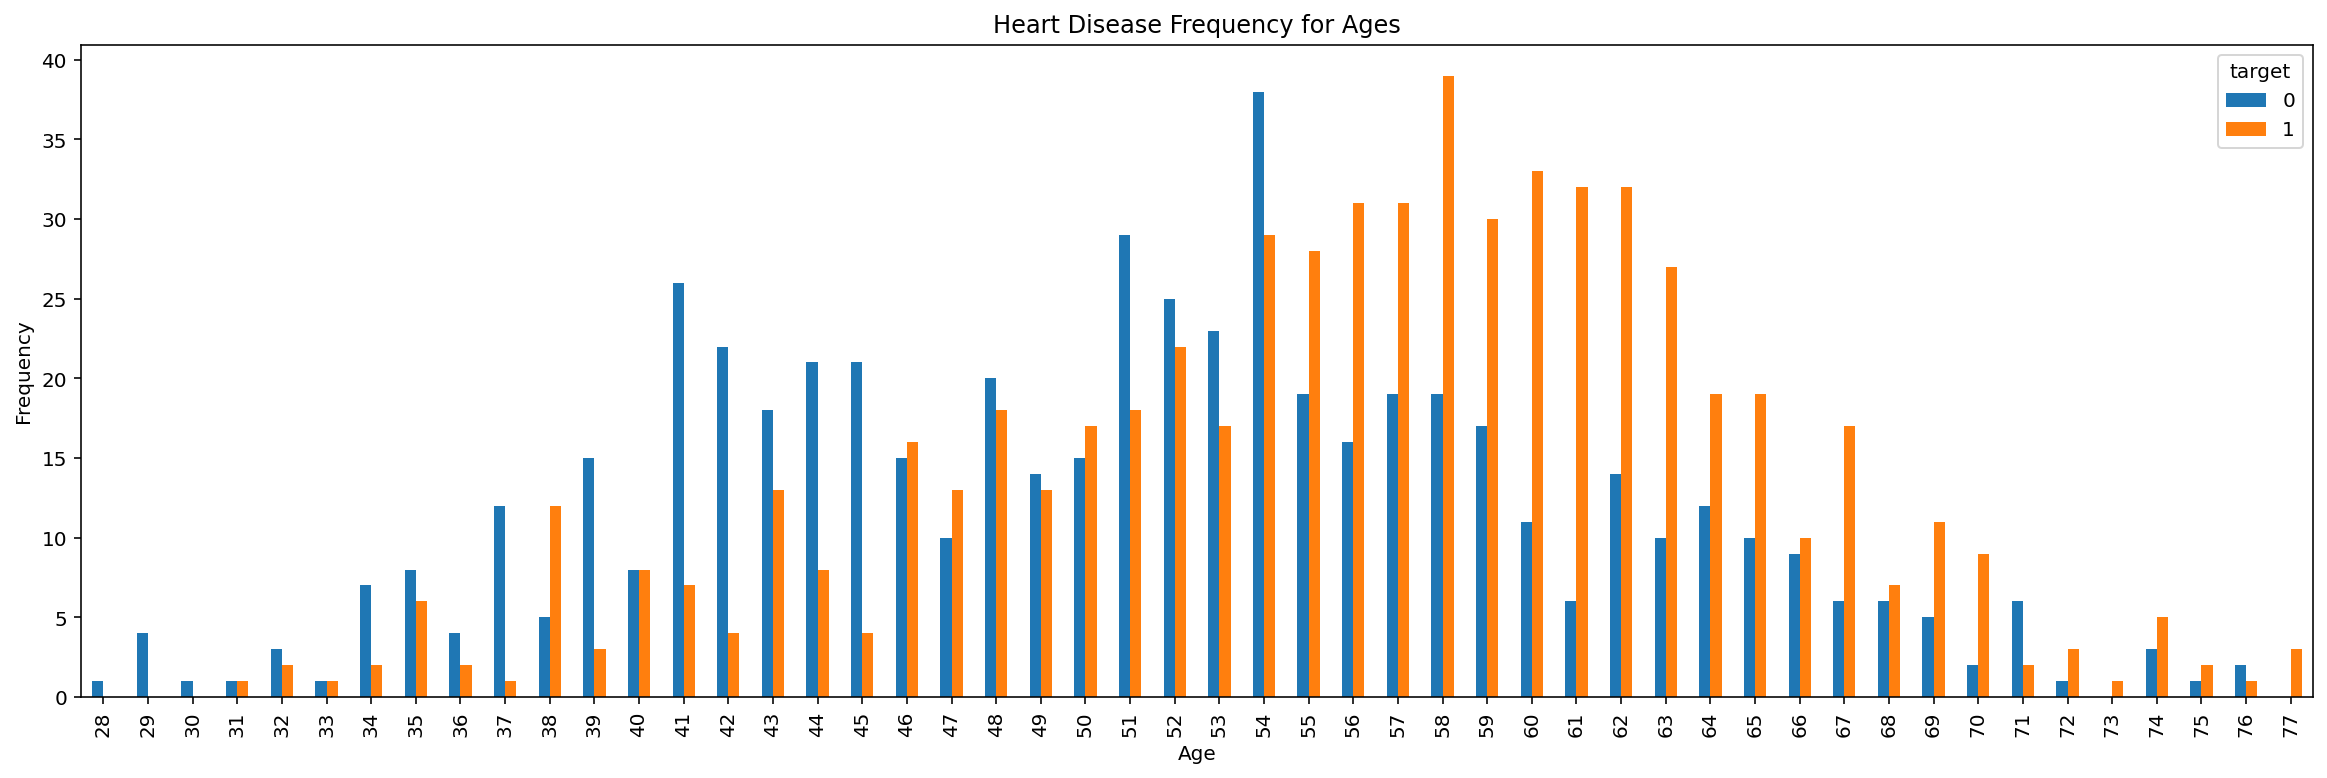

In [49]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(20,6))
plt.title('Heart Disease Frequency for Ages')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('heartDiseaseAndAges.png')
plt.show()

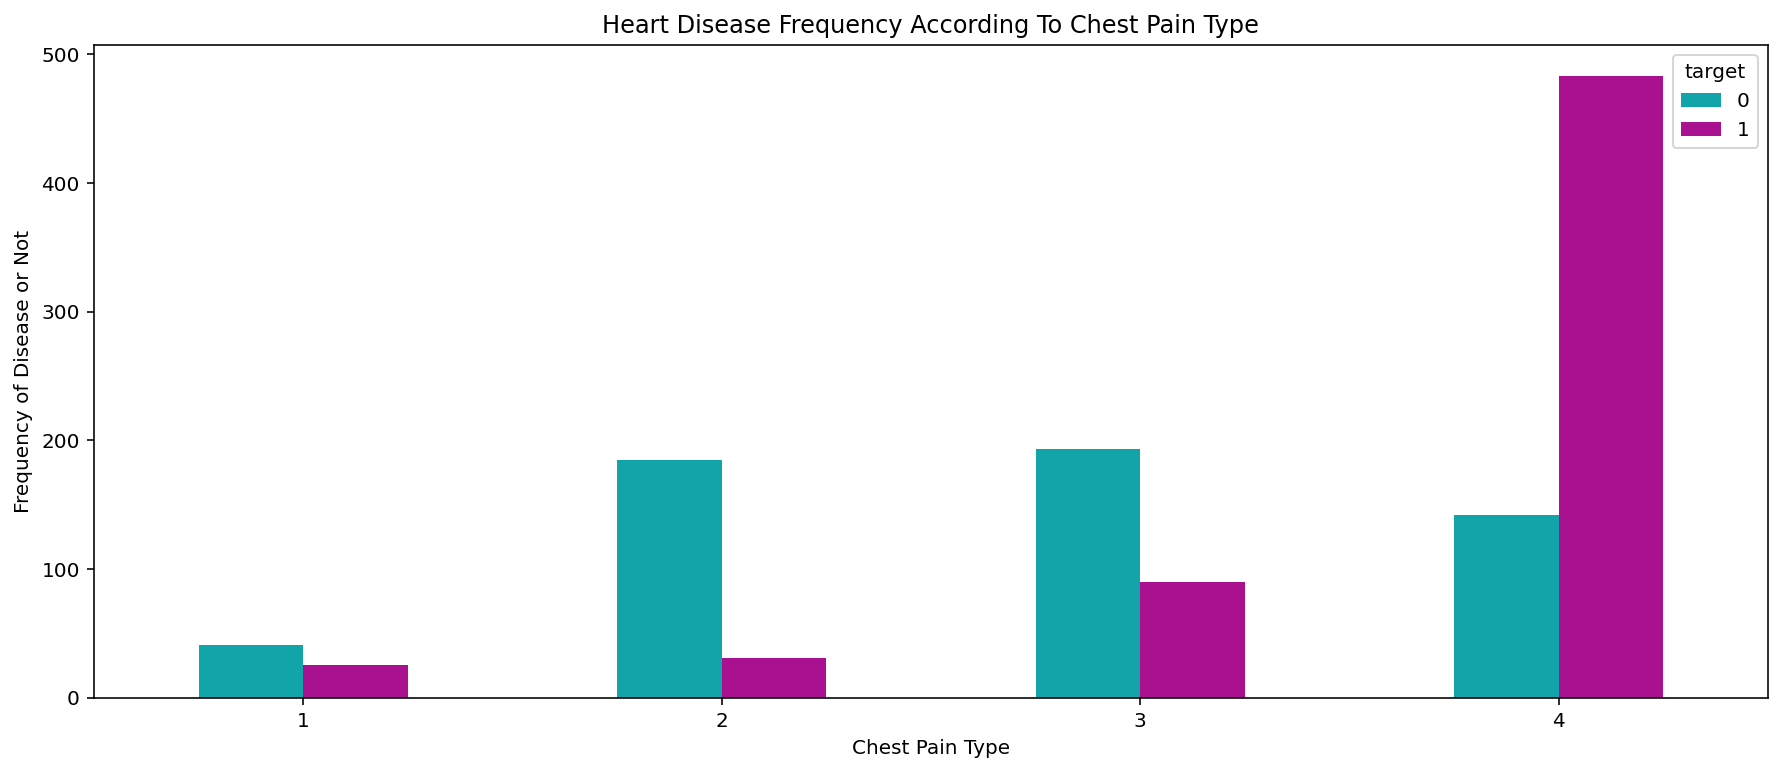

In [50]:
pd.crosstab(df.chest_pain_type,df.target).plot(kind="bar",figsize=(15,6),color=['#11A5AA','#AA1190' ])
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.ylabel('Frequency of Disease or Not')
plt.show()

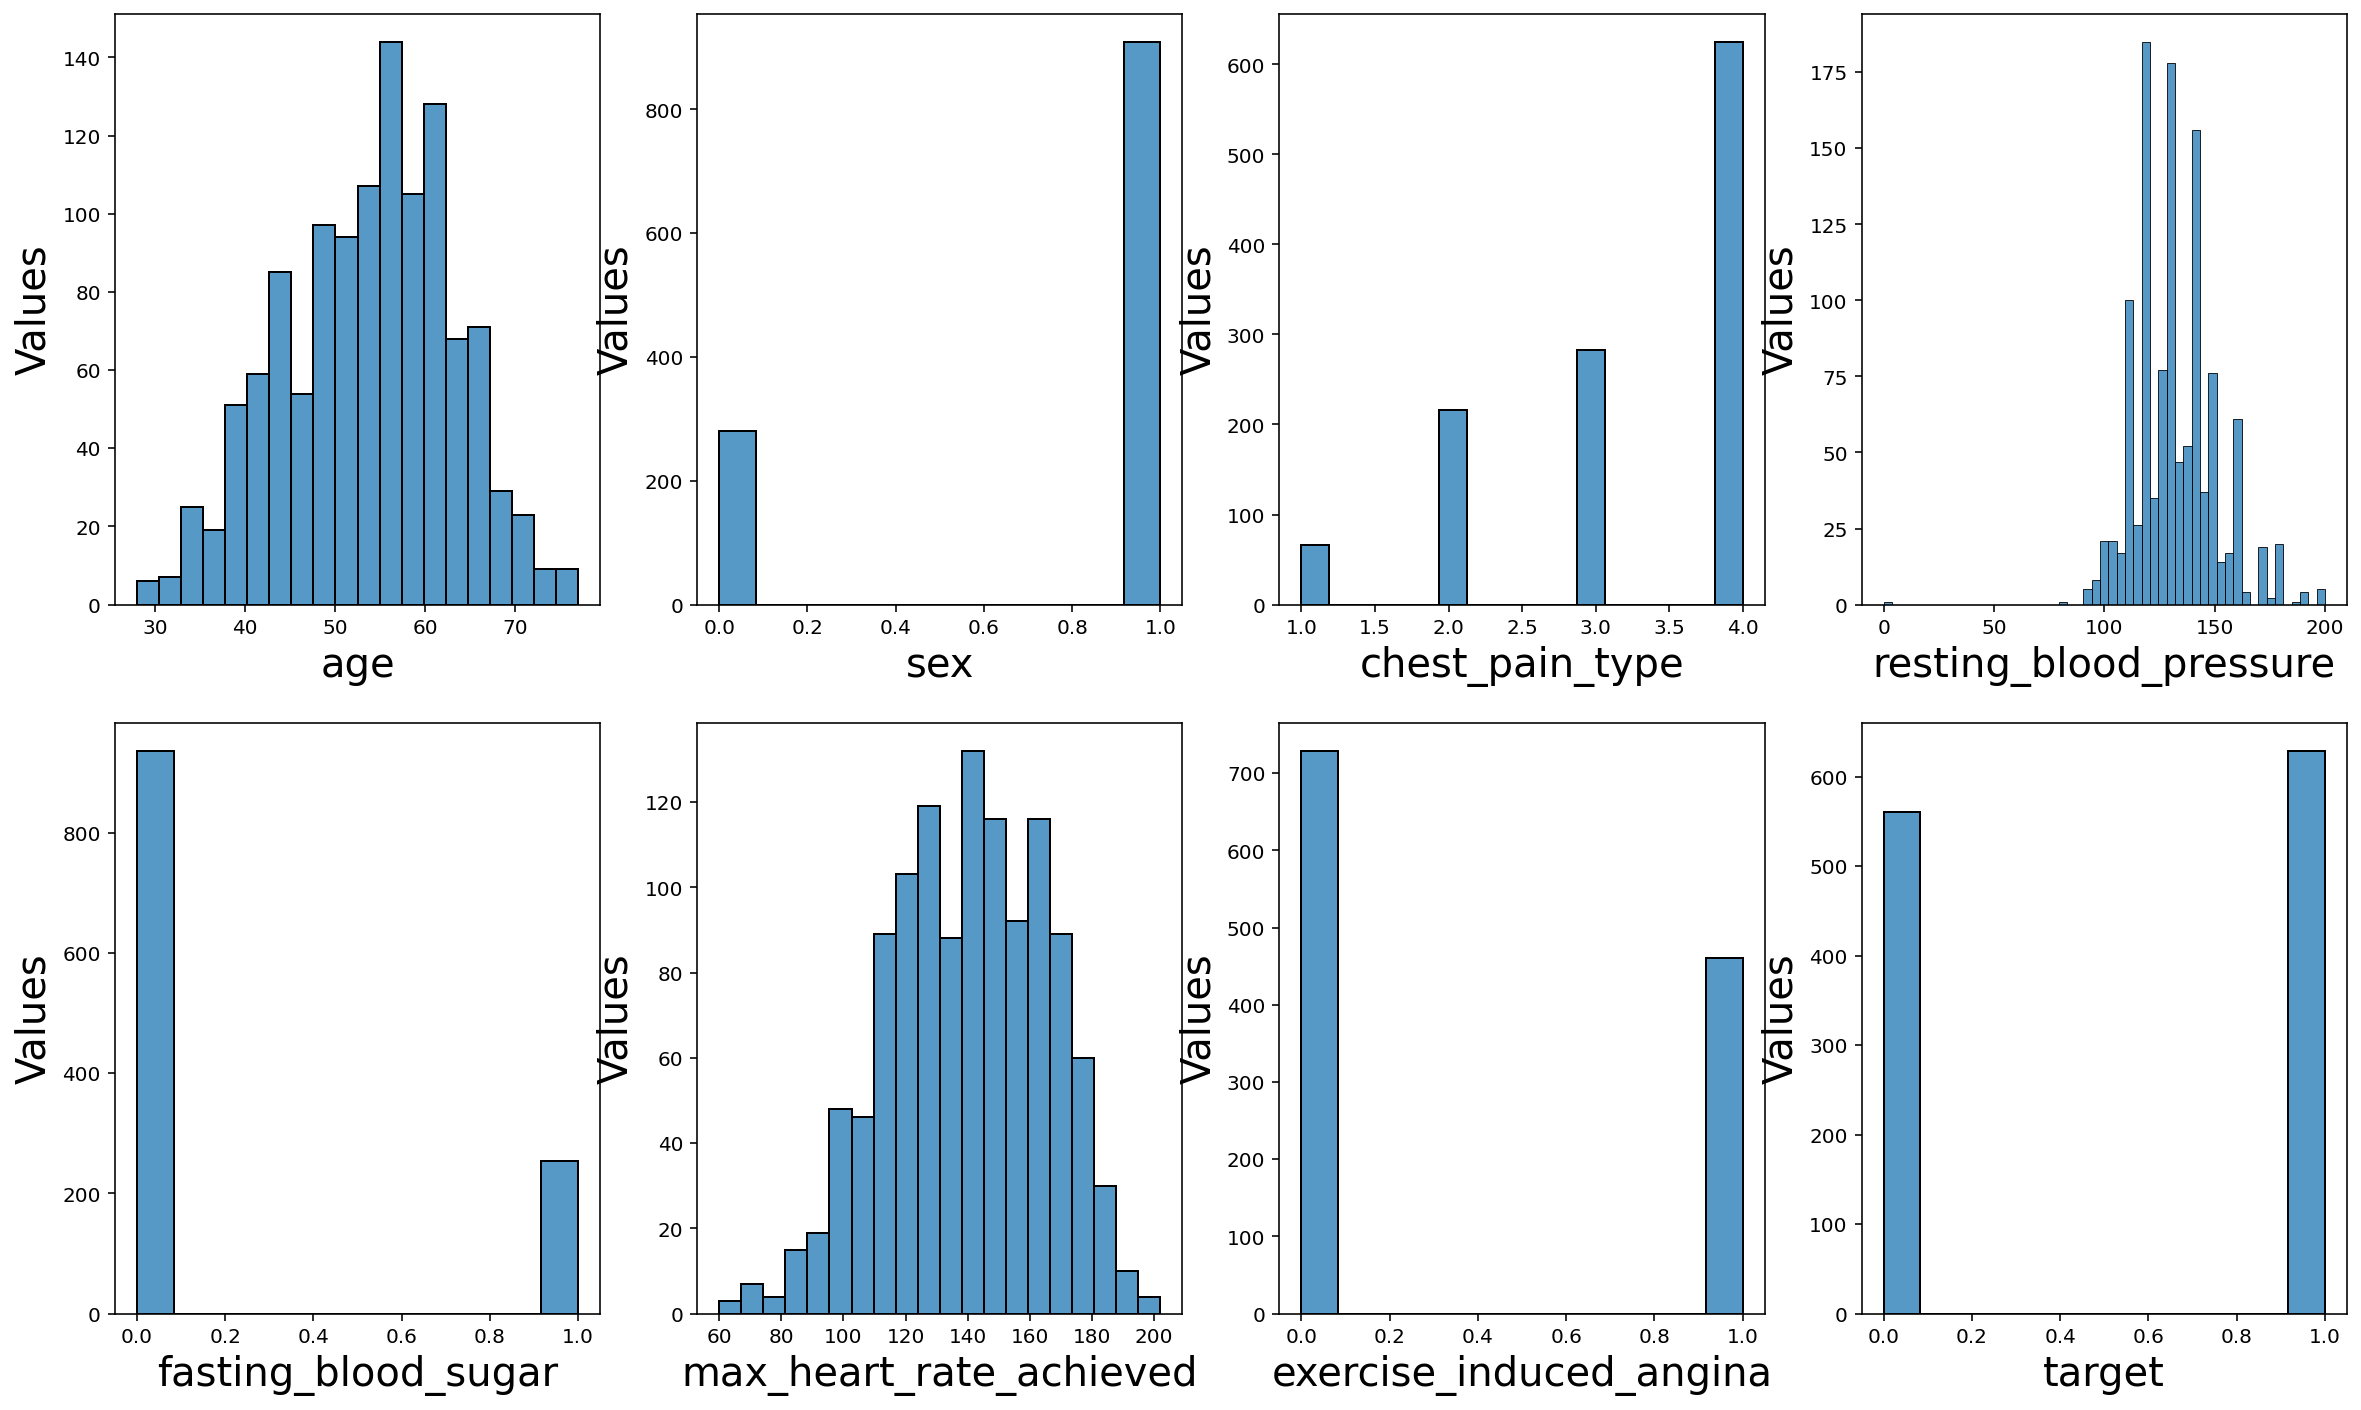

In [51]:
#Plotting the distribution plot.
plt.figure(figsize=(20,25))
plotnumber=1

for column in df:
  if plotnumber<14:
    ax=plt.subplot(4,4,plotnumber)
    sns.histplot(df[column])
    plt.xlabel(column,fontsize=20)
    plt.ylabel('Values',fontsize=20)
  plotnumber+=1
plt.show()

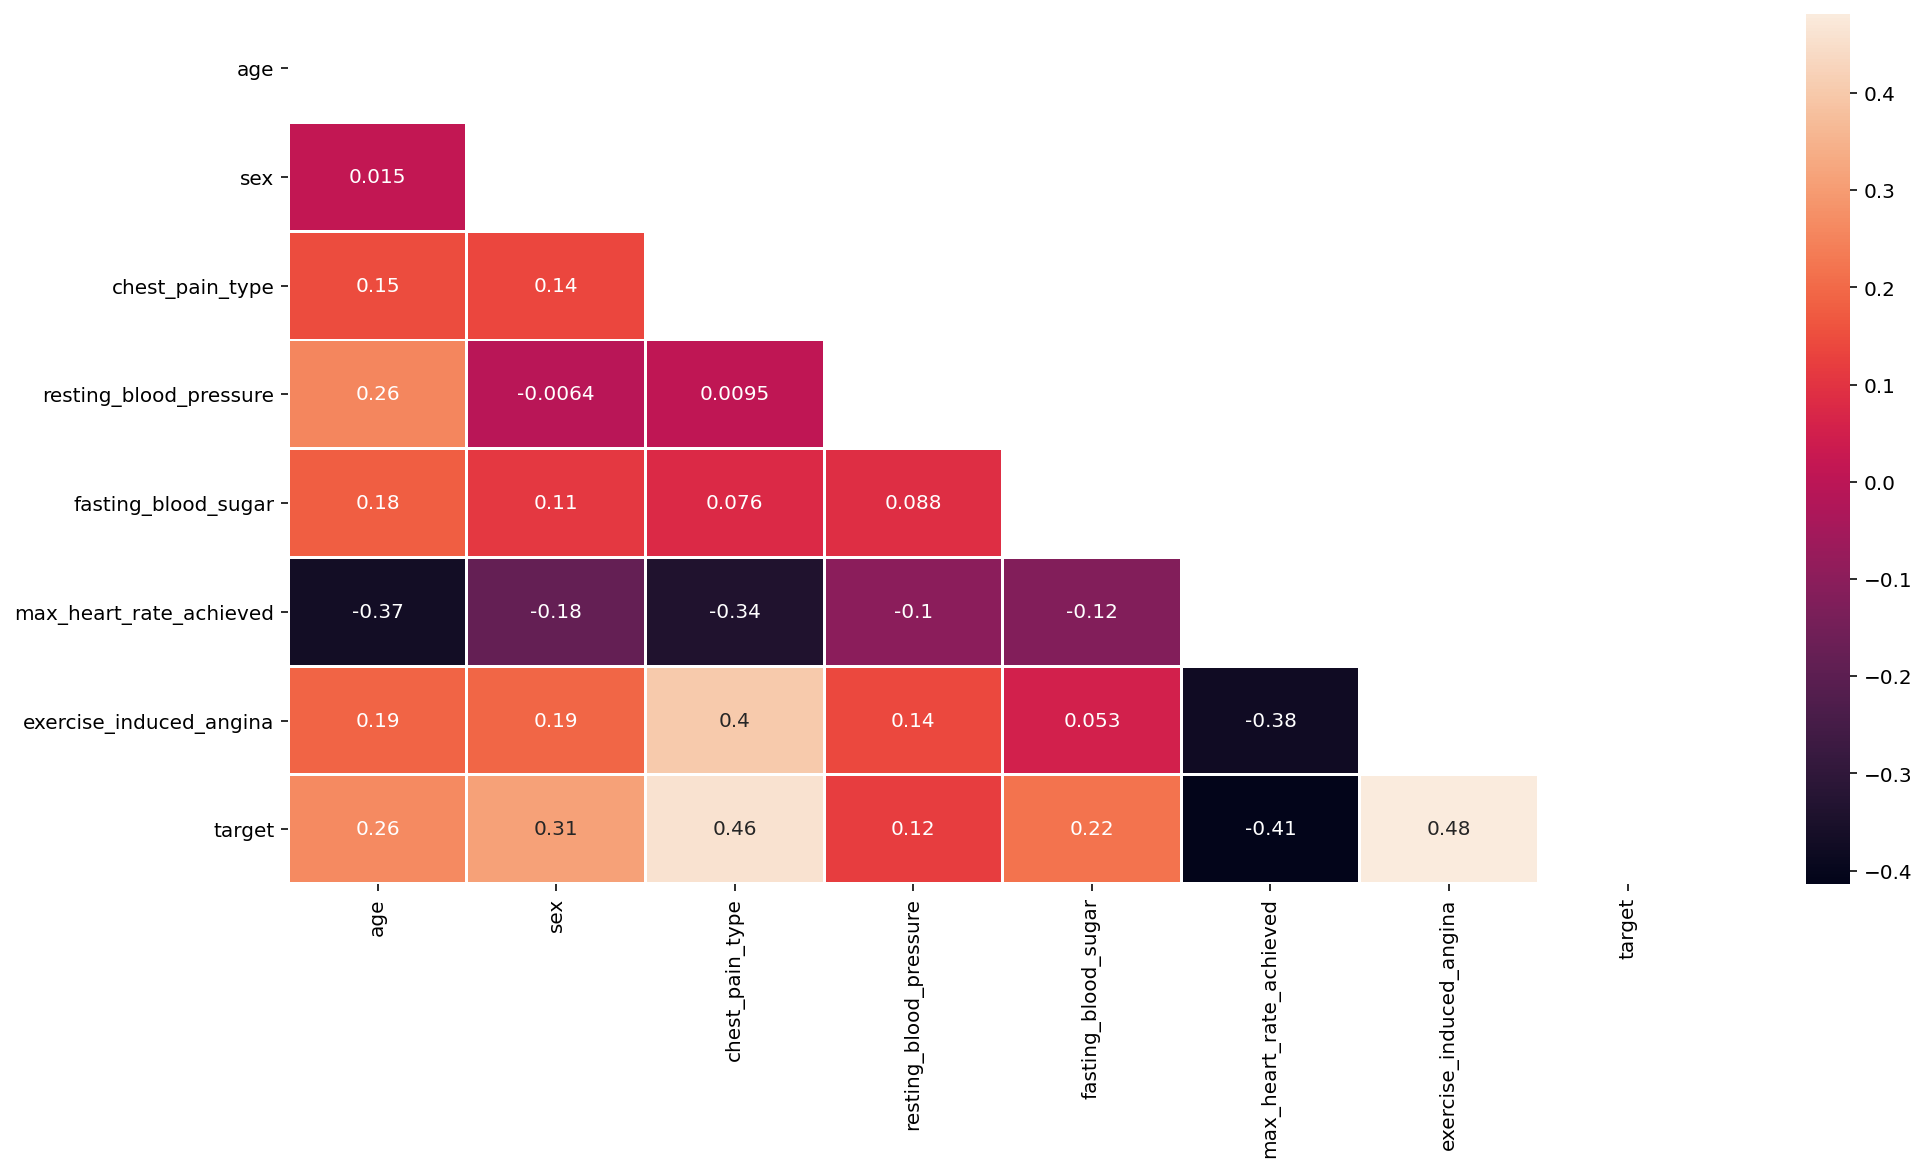

In [52]:
#Correlation matrix

plt.figure(figsize = (16, 8))

corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, annot = True, fmt = '.2g', linewidths = 1)
plt.show()

# Data Pre-prosseing

In [53]:
# Select the columns to use for prediction in the neural network
X = df.drop('target',axis=1)
Y = df['target']
print(X.shape, Y.shape, df.columns)

(1190, 7) (1190,) Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'fasting_blood_sugar', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'target'],
      dtype='object')


In [54]:
# split data into train, test
X_train, X_test, y_train, y_test = train_test_split(X , Y, test_size=0.2,
                                                    random_state=1111, shuffle=True)
# Skipping y since value already 1 or 0
# encoder = LabelEncoder()
# encoder.fit(Y)
# encoded_Y = encoder.transform(Y)

# Normalize data
# scaler = MinMaxScaler()
# scaler = scaler.fit(X)

# X_train_scaled = scaler.transform(X_train)
# X_train = pd.DataFrame(X_train_scaled)

# X_test_scaled = scaler.transform(X_test)
# X_test = pd.DataFrame(X_test_scaled)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(df.columns)

(952, 7) (952,)
(238, 7) (238,)
Index(['age', 'sex', 'chest_pain_type', 'resting_blood_pressure',
       'fasting_blood_sugar', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'target'],
      dtype='object')


# Model Building

In [56]:
# Define some useful callbacks
# Reduce learning rate when a metric has stopped improving.
reducelrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
# Stop training when a monitored quantity has stopped improving. 
# By default, mode is set to ‘auto‘ and knows that you want to minimize loss or maximize accuracy.
early_stopping_monitor=EarlyStopping(monitor='val_loss',verbose=1, patience=30, baseline=0.4, )
# Save the model after every epoch.
best_trained_model_file= 'best_trained_model.h5'
checkpoint = ModelCheckpoint(best_trained_model_file, verbose=0, monitor='val_loss',save_best_only=True, mode='auto')  
#place callbacks want to enable on this list
callbacks=[checkpoint, reducelrp]

In [57]:
# create model with fully connected layers with dropout regulation
model = Sequential()
model.add(Dense(32, input_dim=7, kernel_initializer ='uniform', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(12, kernel_initializer ='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, kernel_initializer ='uniform', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer="Adamax", metrics=['accuracy', f1_m, precision_m, recall_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                256       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                396       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 13        
Total params: 793
Trainable params: 729
Non-trainable params: 64
_________________________________________________________

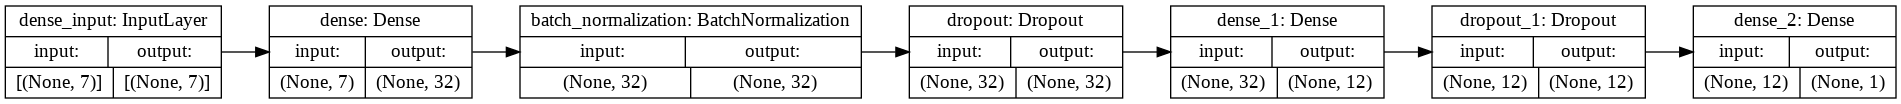

In [58]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [59]:
model.fit(X_train, y_train, validation_split=0.25, epochs=200, batch_size=16, callbacks=callbacks)

Epoch 1/200
45/45 [==============================] - 2s 14ms/step - loss: 0.6892 - accuracy: 0.6531 - f1_m: 0.6720 - precision_m: 0.6676 - recall_m: 0.6978 - val_loss: 0.6786 - val_accuracy: 0.5378 - val_f1_m: 0.1744 - val_precision_m: 0.5667 - val_recall_m: 0.1055
Epoch 2/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.6900 - f1_m: 0.7074 - precision_m: 0.7034 - recall_m: 0.7442 - val_loss: 0.6577 - val_accuracy: 0.6218 - val_f1_m: 0.4436 - val_precision_m: 0.7433 - val_recall_m: 0.3318
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 0.6453 - accuracy: 0.7064 - f1_m: 0.7101 - precision_m: 0.7047 - recall_m: 0.7271 - val_loss: 0.6227 - val_accuracy: 0.7101 - val_f1_m: 0.6631 - val_precision_m: 0.7120 - val_recall_m: 0.6421
Epoch 4/200
45/45 [==============================] - 0s 2ms/step - loss: 0.6116 - accuracy: 0.7118 - f1_m: 0.7141 - precision_m: 0.7229 - recall_m: 0.7214 - val_loss: 0.6027 - val_accuracy: 0.7143 - val_f

# Model Evaluation

In [60]:
print("Evaluate model against trained data")
loss, accuracy, f1_score, precision, recall = model.evaluate(X_train, y_train, verbose=0)
score = model.evaluate(X_train, y_train, verbose=0)
print("accuracy: %.2f%%" % (accuracy*100))
print("f1_score: %.2f%%" % (f1_score*100))
print("precision: %.2f%%" % (precision*100))
print("recall: %.2f%%" % (recall*100))

print("\nEvaluate model against new data")
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
print("accuracy: %.2f%%" % (accuracy*100))
print("f1_score: %.2f%%" % (f1_score*100))
print("precision: %.2f%%" % (precision*100))
print("recall: %.2f%%" % (recall*100))

Evaluate model against trained data
accuracy: 78.47%
f1_score: 78.57%
precision: 81.17%
recall: 76.89%

Evaluate model against new data
accuracy: 80.67%
f1_score: 81.82%
precision: 84.68%
recall: 79.72%


In [66]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

# prediction return class type (1 or 0)
y_pred_class = (model.predict(X_test) > 0.5).astype("int32")
# prediction return proability percentage
y_pred_prob = model.predict(X_test)

# print ("#  original | predicted  | probability  ")
# for idx, label in enumerate(y_test):
#     print ("%s     | %s  | %s |   %.2f%%" % (str(idx), str(label), str(y_pred_class[idx]), float(y_pred_prob[idx])*100))

cm = confusion_matrix(y_test, y_pred_class, labels=[0, 1])
print("Simple confusion matrix\n", cm)

recall_score = recall_score(y_test, y_pred_class)
print('Recall score: {0:0.2f}\n'.format(
      recall_score))

print("Classification Report\n", classification_report(y_test, y_pred_class))

Simple confusion matrix
 [[ 86  19]
 [ 27 106]]
Recall score: 0.80

Classification Report
               precision    recall  f1-score   support

           0       0.76      0.82      0.79       105
           1       0.85      0.80      0.82       133

    accuracy                           0.81       238
   macro avg       0.80      0.81      0.81       238
weighted avg       0.81      0.81      0.81       238



# References

https://keras.io/examples/structured_data/structured_data_classification_from_scratch/

https://www.kaggle.com/anshigupta01/heart-disease-classification

https://www.kaggle.com/mychen76/heart-disease-classification-with-keras

https://www.kaggle.com/abdelsamad/heart-disease-prediction-with-neural-networks

